# Spike Challenge - Predicción de precios de insumos básicos en Chile

*Autor: Sebastián Orellana*

Este documento tiene por objetivo la predicción del precio de la leche en Chile, por medio de múltiples series de tiempo mensuales relacionadas con variables climatográficas e índices macroeconómicos. 


**Librerías utilizadas**

In [146]:
import pandas as pd

from math import sqrt

import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

### 1. Datos: Precipitaciones, Indicadores Económicos Banco Central

Se cargan los datasets:

- ***precipitaciones.csv***: series de tiempo con las precipitaciones medias mensuales [mm] registradas entre enero 1979 y abril 2020. 
- ***banco_central.csv***: series de tiempo mensuales con variables económicas.

In [206]:
df_precipitations = pd.read_csv('precipitaciones.csv')
df_central_bank  = pd.read_csv('banco_central.csv')

### 2. Análisis de datos

A continuación se realiza un análisis exploratorio de ambos datasets.

##### Precipitaciones:

Para dar una idea general del estado del dataset (tamaño, tipo de datos, # datos duplicados y # valores faltantes) se realiza la siguiente función:

In [118]:
def dataset_status(df):
    size = df.shape
    print('- Cantidad de variables: {} \n'.format(size[1]))
    print('- Cantidad de datos: {} \n'.format(size[0]))
    print('- Tipo de datos: \n{} \n'.format(df.dtypes))
    print('- # datos duplicados: {} \n'.format(df[df.duplicated()].shape[0]))
    print('- # valores faltantes: \n{} \n'.format(df.isnull().sum()))

In [119]:
dataset_status(df_precipitations)

- Cantidad de variables: 9 

- Cantidad de datos: 496 

- Tipo de datos: 
date                                    object
Coquimbo                               float64
Valparaiso                             float64
Metropolitana_de_Santiago              float64
Libertador_Gral__Bernardo_O_Higgins    float64
Maule                                  float64
Biobio                                 float64
La_Araucania                           float64
Los_Rios                               float64
dtype: object 

- # datos duplicados: 0 

- # valores faltantes: 
date                                   0
Coquimbo                               0
Valparaiso                             0
Metropolitana_de_Santiago              0
Libertador_Gral__Bernardo_O_Higgins    0
Maule                                  0
Biobio                                 0
La_Araucania                           0
Los_Rios                               0
dtype: int64 



Con esto tenemos una primera impresión del dataset, que parece estar bastante limpio: sin duplicados ni valores faltantes, además de tipo de datos homogéneos. Ahora exploremos los datos:

In [120]:
df_precipitations.head()

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
0,1989-02-01,0.719033,0.117045,0.028272,0.0,0.724667,9.172945,22.595834,52.268010
1,1998-10-01,0.065216,0.000000,0.011493,0.0,0.008968,2.089674,14.702087,45.142041
2,2001-02-01,2.030026,0.047987,0.002634,0.0,0.032163,10.768351,29.465057,65.571098
3,2008-11-01,0.622784,0.000000,0.015872,0.0,1.734168,25.083557,64.901645,113.093488
4,2009-04-01,0.008065,0.000000,0.009396,0.0,12.080715,56.233424,96.364235,155.622235


Se setea la columna 'date' como indice (con formato Año-Mes, sin pérdida de información):

In [207]:
df_precipitations['date'] = pd.to_datetime(df_precipitations['date']).dt.to_period('M')
df_precipitations.set_index('date', inplace=True)
df_precipitations.sort_index(inplace=True)

Y algunas métricas estadísticas escenciales:

In [122]:
df_precipitations.describe()

,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
count,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,16.154691,32.450980,49.666682,72.249805,98.662773,128.113406,151.486456,199.451789
std,32.629286,55.434330,74.361099,101.426112,122.766771,130.056094,126.628503,140.073615
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.001170,0.005331,0.748127
25%,0.821521,1.538162,5.297546,5.343992,11.897363,29.356684,52.930343,89.805643
50%,4.071036,9.037825,19.087592,25.995969,45.649888,79.558557,110.570990,159.467940
75%,16.137600,38.409213,63.408364,101.875093,142.230716,184.751307,208.316243,274.594590
max,347.133889,441.048604,524.592667,645.515752,759.177712,702.434707,661.211203,717.735673


Así, se corrobora la intuición que las precipitaciones en Chile en promedio tienden a aumentar a medida que nos desplazamos al sur (y también la volatilidad del clima, interpretado a partir de las respectivas desviaciones estándar). Es interesante ver sin embargo, que la cantidad de [mm] mensual más alta se registró en la región del Maule. Para indagar en este fenómeno se grafica la distribución de los datos de esta región:

<AxesSubplot:>

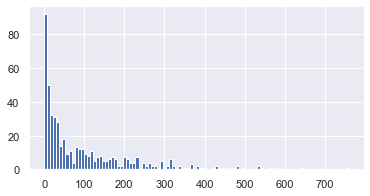

In [123]:
df_precipitations['Maule'].hist(bins=100, figsize=[6,3])

En efecto, las precipitaciones mensuales en Maule parecieran seguir una distribución libre de escala $P(K)\sim k^\gamma, \gamma \in [2,3]$, donde muchos meses registran pocas precipitaciones, mientras que unos pocos meses registran fuertes precipitaciones. Una forma alternativa de estudio son los boxplot:

[Text(0.5, 1.0, 'Precipitaciones en Maule'), Text(0.5, 0, '[mm]')]

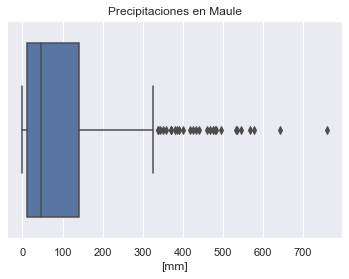

In [124]:
sns.boxplot(x=df_precipitations["Maule"]).set(title='Precipitaciones en Maule', xlabel='[mm]')

Que según lo esperado, presenta bastantes outliers. Si bien, este análisis exploratorio podría y debiese ser considerablemente más exhaustivo (estudio de distribuciones para cada región, visualizaciones, más métricas, etc.), en este documento se priorizará la simplicidad. Aún así, es importante incluir métricas que adviertan correlación entre variables:

<AxesSubplot:>

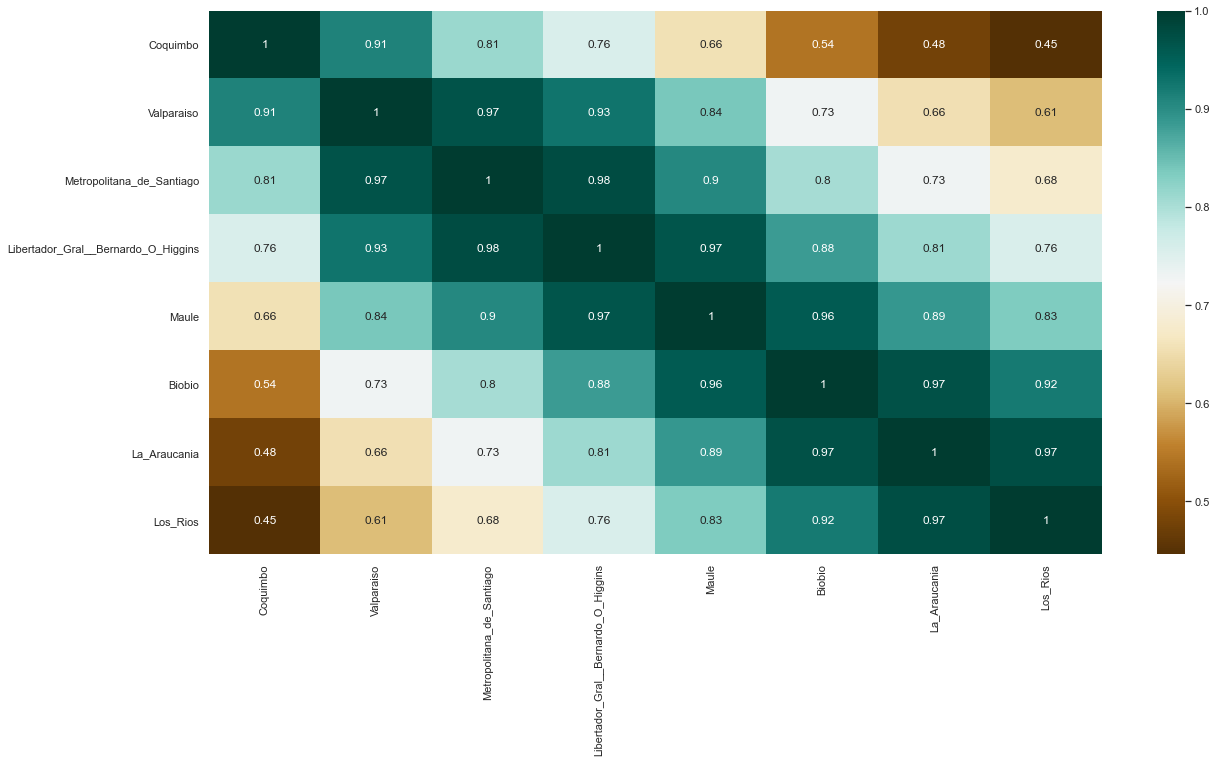

In [125]:
plt.figure(figsize=(20,10))
c= df_precipitations.corr()
sns.heatmap(c,cmap="BrBG",annot=True)

Este mapa de calor ofrece información respecto a relaciones lineales entre variables. Por ejemplo, se advierte una fuerte correlación climatológica entre la sexta región y la metropolitana, que podría conducir a estudios futuros de causalidad.

##### Banco central:

Se repite el proceso para el dataset del banco central:

In [126]:
dataset_status(df_central_bank)

- Cantidad de variables: 85 

- Cantidad de datos: 614 

- Tipo de datos: 
Periodo                                             object
Imacec_empalmado                                    object
Imacec_produccion_de_bienes                         object
Imacec_minero                                       object
Imacec_industria                                    object
                                                    ...   
Generacion_de_energia_electrica_CDEC_GWh            object
Indice_de_ventas_comercio_real_IVCM                 object
Indice_de_ventas_comercio_real_no_durables_IVCM     object
Indice_de_ventas_comercio_real_durables_IVCM        object
Ventas_autos_nuevos                                float64
Length: 85, dtype: object 

- # datos duplicados: 2 

- # valores faltantes: 
Periodo                                              0
Imacec_empalmado                                   314
Imacec_produccion_de_bienes                        314
Imacec_minero                    

A diferencia del caso anterior, los datos del banco central demandan una limpieza. En términos generales, la cantidad de datos es reducida (considerando la alta dimensionalidad del dataset), por lo que el criterio que guiará el proceso de limpieza es tratar de mantener la mayor cantidad de datos mientras se intenta reducir la dimensionalidad, para así desfavorecer la presencia de futuro overfitting. Primeramente se eliminan los datos duplicados (2):

In [208]:
df_central_bank.drop_duplicates(inplace=True)

Luego de advertir que hay un datetime malformado ('2020-13-01'), se reemplaza por el valor que se intuye correcto ('2020-12-01'), y se setea el índice:

In [209]:
df_central_bank['Periodo']= df_central_bank['Periodo'].str.replace('2020-13-01 00:00:00 UTC','2020-12-01 00:00:00 UTC')
df_central_bank['Periodo'] = pd.to_datetime(df_central_bank['Periodo']).dt.to_period('M')
df_central_bank.set_index('Periodo', inplace=True)
df_central_bank.sort_index(inplace=True)

/Users/sebaorellana/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


A continuación se procede a reducir la dimensionalidad. Cabe destacar que mis conocimientos de economía son prácticamente nulos, y el estudio de cada métrica se escapa del ámbito de este desfío. Por lo tanto, por simplicidad, el criterio de eliminación de variables es el siguiente: se mantienen columnas asociadas a Imacec y PIB y todas aquellas con datos faltantes menor a 200:

In [210]:
drop_columns = df_central_bank.columns[44:].tolist()
drop_columns.remove('Tipo_de_cambio_del_dolar_observado_diario')
df_central_bank = df_central_bank.drop(drop_columns, axis=1)

Luego, se estandariza el tipo de datos. En general, se advierte que toda columna de tipo 'object' tiene mal formaciones, y se corrigen como sigue:

In [211]:
for column in df_central_bank.columns:
    if df_central_bank[column].dtype=='object':
        df_central_bank[column] = df_central_bank[column].str.replace('.','')
        df_central_bank[column] = df_central_bank[column].str.replace(',','.')
        
        df_central_bank[column] = pd.to_numeric(df_central_bank[column], errors = 'coerce')
        df_central_bank[column] = df_central_bank[column].astype('float')

<ipython-input-211-6e58b4416520>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_central_bank[column] = df_central_bank[column].str.replace('.','')


Con esto, con el espíritu de no decrecer el dataset se procede a llenar los datos faltantes. Se escoge la mediana como criterio de interpolación, principalmente por simplicidad. Dentro de las opciones rápidas, la mediana pareció ligeramente más razonable, pues no es dañada por los fuertes outliers del dataset (como sí lo es la media). Sin embargo, escoger valores constantes hiere completamente toda intuición de estacionalidad de los datos. Un enfoque más adecuado para completar datos con largos períodos de tiempo faltantes hubiese consistido, por ejemplo, en ajustar un modelo ARIMA a cada serie de tiempo (con su respectivo estudio de estacionalidad y tendencia), y utilizar sus predicciones para completar el dataset: 

In [212]:
df_central_bank = df_central_bank.fillna(df_central_bank.median())

In [188]:
df_central_bank.head()

,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,PIB_Agropecuario_silvicola,PIB_Pesca,PIB_Mineria,PIB_Mineria_del_cobre,PIB_Otras_actividades_mineras,PIB_Industria_Manufacturera,PIB_Alimentos,PIB_Bebidas_y_tabaco,PIB_Textil,PIB_Maderas_y_muebles,PIB_Celulosa,PIB_Refinacion_de_petroleo,PIB_Quimica,PIB_Minerales_no_metalicos_y_metalica_basica,PIB_Productos_metalicos,PIB_Electricidad,PIB_Construccion,PIB_Comercio,PIB_Restaurantes_y_hoteles,PIB_Transporte,PIB_Comunicaciones,PIB_Servicios_financieros,PIB_Servicios_empresariales,PIB_Servicios_de_vivienda,PIB_Servicios_personales,PIB_Administracion_publica,PIB_a_costo_de_factores,Impuesto_al_valor_agregado,Derechos_de_Importacion,PIB,Precio_de_la_gasolina_en_EEUU_dolaresm3,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_cobre_refinado_BML_dolareslibra,Precio_del_diesel_centavos_de_dolargalon,Tipo_de_cambio_del_dolar_observado_diario
Periodo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1970-01,565593693.0,752522065.0,864828629.0,740851214.5,630182007.0,446592688.0,479736954.5,572351303.0,524448935.5,271003281.0,558510477.0,126387596.0,115237183.0,131243053.5,127904447.0,334311036.0,163386082.0,291854267.0,687326006.0,106138814.0,114125569.0,189190731.0,692896868.0,212645875.0,323127447.0,727233884.0,111995607.0,228180032.0,587011122.0,395834581.0,628677082.0,122135646.0,886315007.0,152467409.0,567576286.0,109937357.0,883855814.0,528192423.0,120652343.0,22447.5,34.94,1.88,738.0,200.34,405286136.5
1970-02,565593693.0,752522065.0,864828629.0,740851214.5,630182007.0,446592688.0,479736954.5,572351303.0,524448935.5,271003281.0,558510477.0,126387596.0,115237183.0,131243053.5,127904447.0,334311036.0,163386082.0,291854267.0,687326006.0,106138814.0,114125569.0,189190731.0,692896868.0,212645875.0,323127447.0,727233884.0,111995607.0,228180032.0,587011122.0,395834581.0,628677082.0,122135646.0,886315007.0,152467409.0,567576286.0,109937357.0,883855814.0,528192423.0,120652343.0,22447.5,34.99,1.90,752.0,200.34,405286136.5
1970-03,565593693.0,752522065.0,864828629.0,740851214.5,630182007.0,446592688.0,479736954.5,572351303.0,524448935.5,271003281.0,558510477.0,126387596.0,115237183.0,131243053.5,127904447.0,334311036.0,163386082.0,291854267.0,687326006.0,106138814.0,114125569.0,189190731.0,692896868.0,212645875.0,323127447.0,727233884.0,111995607.0,228180032.0,587011122.0,395834581.0,628677082.0,122135646.0,886315007.0,152467409.0,567576286.0,109937357.0,883855814.0,528192423.0,120652343.0,22447.5,35.09,1.89,796.0,200.34,405286136.5
1970-04,565593693.0,752522065.0,864828629.0,740851214.5,630182007.0,446592688.0,479736954.5,572351303.0,524448935.5,271003281.0,558510477.0,126387596.0,115237183.0,131243053.5,127904447.0,334311036.0,163386082.0,291854267.0,687326006.0,106138814.0,114125569.0,189190731.0,692896868.0,212645875.0,323127447.0,727233884.0,111995607.0,228180032.0,587011122.0,395834581.0,628677082.0,122135646.0,886315007.0,152467409.0,567576286.0,109937357.0,883855814.0,528192423.0,120652343.0,22447.5,35.62,1.85,79.0,200.34,405286136.5
1970-05,565593693.0,752522065.0,864828629.0,740851214.5,630182007.0,446592688.0,479736954.5,572351303.0,524448935.5,271003281.0,558510477.0,126387596.0,115237183.0,131243053.5,127904447.0,334311036.0,163386082.0,291854267.0,687326006.0,106138814.0,114125569.0,189190731.0,692896868.0,212645875.0,323127447.0,727233884.0,111995607.0,228180032.0,587011122.0,395834581.0,628677082.0,122135646.0,886315007.0,152467409.0,567576286.0,109937357.0,883855814.0,528192423.0,120652343.0,22447.5,35.95,1.67,725.0,200.34,405286136.5


Se evidencia que los datos faltantes asociados al Imacec eran para los períodos iniciales, caso contrario a los del PIB. Y ahora es factible un análisis exploratorio análogo al realizado con las precipitaciones. Mas dada la complejidad de las métricas, las incerteza del valor de los datos recuperados, y mi poco conocimiento específico de economía, se ignoran los análisis más detallados. Aún así, se presentan la descripción general:

In [133]:
df_central_bank.describe()

,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,PIB_Agropecuario_silvicola,...,PIB_a_costo_de_factores,Impuesto_al_valor_agregado,Derechos_de_Importacion,PIB,Precio_de_la_gasolina_en_EEUU_dolaresm3,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_cobre_refinado_BML_dolareslibra,Precio_del_diesel_centavos_de_dolargalon,Tipo_de_cambio_del_dolar_observado_diario
count,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,...,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,6.120000e+02,612.000000,612.000000,6.120000e+02,612.000000,6.120000e+02
mean,5.371902e+08,6.846363e+08,7.584431e+08,6.798718e+08,5.940321e+08,4.546640e+08,4.621890e+08,5.357542e+08,5.042000e+08,2.776769e+08,...,1.120829e+08,8.384893e+08,5.223117e+08,1.195434e+08,1.533616e+07,575.862925,53.775056,8.933923e+07,204.572271,3.514877e+08
std,2.239026e+08,2.507218e+08,2.850013e+08,2.477142e+08,2.211077e+08,2.059361e+08,2.147138e+08,2.261780e+08,2.186063e+08,7.421771e+07,...,6.281272e+07,1.931443e+08,7.265446e+07,1.190649e+07,2.346567e+07,466.284385,89.377016,1.335772e+08,36.911182,2.441427e+08
min,5.296994e+06,1.014872e+06,1.010200e+07,1.032193e+06,1.027326e+06,4.237199e+06,7.563720e+05,9.371354e+06,9.043380e+05,1.586778e+07,...,1.158010e+05,9.452492e+06,5.852693e+06,1.108406e+07,9.900000e+01,34.940000,1.320000,1.000000e+00,79.490000,4.701000e+03
25%,5.655937e+08,7.525221e+08,8.648286e+08,7.408512e+08,6.301820e+08,4.465927e+08,4.797370e+08,5.723513e+08,5.244489e+08,2.710033e+08,...,1.099374e+08,8.838558e+08,5.281924e+08,1.206523e+08,1.262975e+04,292.112500,4.757500,1.235000e+02,200.340000,4.785844e+07
50%,5.655937e+08,7.525221e+08,8.648286e+08,7.408512e+08,6.301820e+08,4.465927e+08,4.797370e+08,5.723513e+08,5.244489e+08,2.710033e+08,...,1.099374e+08,8.838558e+08,5.281924e+08,1.206523e+08,2.244750e+04,384.840000,6.060000,7.440000e+02,200.340000,4.052861e+08
75%,5.655937e+08,7.525221e+08,8.648286e+08,7.408512e+08,6.301820e+08,4.465927e+08,4.797370e+08,5.723513e+08,5.244489e+08,2.710033e+08,...,1.099374e+08,8.838558e+08,5.281924e+08,1.206523e+08,3.053359e+07,811.760000,32.361750,2.073240e+08,200.340000,5.126542e+08
max,9.998748e+08,9.992728e+08,9.975769e+08,9.992121e+08,9.995847e+08,9.971810e+08,9.964286e+08,9.981539e+08,9.972512e+08,7.046145e+08,...,9.978396e+08,9.930879e+08,8.001294e+08,1.405737e+08,8.663911e+07,1969.780000,431.028000,4.363259e+08,384.380000,9.188909e+08


### 3. Visualización

En el contexto de ampliar el análisis exploratorio y entender mejor los datos, se procede a visualizar algunos datos relevantes de cada dataset.

##### Precipitaciones:

La siguiente función permite grafica series históricas de precipitaciones para una región y rango de fechas determinados:

In [134]:
def plot_precipitations_by_dates(region, start_date, stop_date):
    if region not in df_precipitations:
        print("Region no está en dataset")
        return
    if start_date not in df_precipitations.index:
        print("start date no está en  dataset")
        return
    if stop_date not in df_precipitations.index:
        print("start date no está en dataset")
        return
    df_precipitations[region][start_date:stop_date].plot(y='[mm]', legend=region)

Luego, se usa esta función para graficar las precipitaciones para la región Libertador General Bernardo O'Higgins y para la región Metropolitana entre las fechas 2000-01-01 y 2020-01-01:

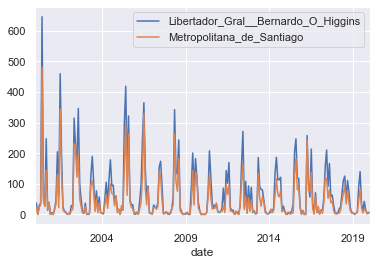

In [135]:
plot_precipitations_by_dates('Libertador_Gral__Bernardo_O_Higgins', '2000-01', '2020-01')
plot_precipitations_by_dates('Metropolitana_de_Santiago', '2000-01', '2020-01')

Según lo esperado, existe correlación entre ambas series de tiempo, con precipitaciones levemente inferiores para la región Metropolitana. Se observa una estacionalidad justificada por alzas de las precipitaciones en invierno y temporadas más secas en verano. Si bien un análisis de ACF (auto-correlation function) y PACF (partial auto-correlation function) es escencial para un estudio detallado de este fenómeno, por simplicidad, el conocimiento específico del tema se considera suficiente para aprobar estacionalidad. Muy interesante también es la tendencia decreciente de las precipitaciones. Se hipotetiza que es una consecuencia del cambio climático.

Ahora, se crea una función que, para una región, grafique múltiples series de tiempo mensuales de precipitaciones, donde cada serie de tiempo corresponda a un año:

In [87]:
def plot_annual_precipitations(region, years):
    months = ["ene", "feb","mar", "abr","may", "jun","jul", "ago","sep", "oct","nov", "dic"]
    
    if region not in df_precipitations:
        print("Región no está en dataset")
        return
    for year in years:
        if str(year)+'-01' not in df_precipitations.index:
            print("Año {} no está en dataset".format(year))
            return
        
        plt.plot(months, df_precipitations[region][str(year)+'-01-01':str(year)+'-12-01'])
        
    plt.legend([str(year) for year in years])
    plt.ylabel('[mm]')

Se grafican las precipitaciones para la región del Maule durante los años 1982, 1992, 2002, 2012 y 2019:

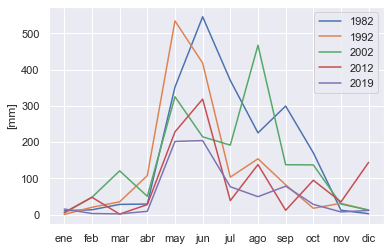

In [88]:
years = [1982, 1992, 2002, 2012, 2019]
plot_annual_precipitations('Maule', years)

La principal conclusión de este gráfico son la corroboración de la tendencia a disminuir las precipitaciones con los años. Adcional a la consecuente sequía, resulta interesante una tendencia a la homogeneidad climática con el paso de los años, es decir, con los pics de lluvias invernales disminuyendo notoriamente, las estaciones son cada vez más parecidas entre sí. 

##### Banco central:

Ahora, una función que permita visualizar dos series históricas de PIB para un rango de fechas determinado:

In [90]:
def plot_pib_by_dates(economic_index, start_date, stop_date):
    if economic_index not in df_central_bank:
        print("Índice no está en dataset")
        return
    if start_date not in df_central_bank.index:
        print("start date no está en the dataset")
        return
    if stop_date not in df_central_bank.index:
        print("start date no está en the dataset")
        return
    df_central_bank[economic_index][start_date:stop_date].plot(legend=economic_index)

Luego, se grafica las series de tiempo del PIB agropecuario y silvícola y la del PIB de Servicios financieros desde el 2013-01-01 hasta la fecha más reciente con datos:

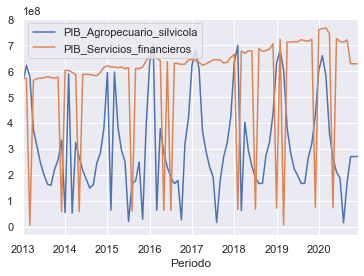

In [93]:
plot_pib_by_dates('PIB_Agropecuario_silvicola','2013-01',df_central_bank.index[-1])
plot_pib_by_dates('PIB_Servicios_financieros','2013-01',df_central_bank.index[-1])

Ambas series presentan cambios muy drásticos. El PIB de servicios financieros, a pesar de su volatibilidad no evidencia tendencias, mientras que el PIB agropecuario y sivícola presenta una leve tendencia al alza. Además, se hipotetiza que ambas series de tiempo tienen una correlación directa con algún desfase temporal, es decir, bajas en el PIB agropecuario y sivícola tienden a percibirse como bajas en el PIB de servicios financieros en un período posterior. 

### 4. Tratamiento y creación de variables

A continuación se incluyen los datos mensuales del precio de la leche en chile:

In [213]:
df_milk_price = pd.read_csv('precio_leche.csv')
df_milk_price.head()

,Anio,Mes,Precio_leche
0,1979,Ene,3.85
1,1979,Feb,4.58
2,1979,Mar,5.18
3,1979,Abr,6.06
4,1979,May,7.25


Para el entrenamiento del modelo, queremos predecir el precio de la leche para el productor en Chile. Se hace un merge con los datasets de precipitaciones y datos del Banco Central. Para ello, es necesario modificar el indice temporal:

In [214]:
df_milk_price.Mes = df_milk_price.Mes.str.replace('Ene','01').replace('Feb','02').replace('Mar','03').replace('Abr','04').replace('May','05').replace('Jun','06').replace('Jul','07').replace('Ago','08').replace('Sep','09').replace('Oct','10').replace('Nov','11').replace('Dic','12')
df_milk_price['Periodo'] = df_milk_price.Anio.astype(str) + '-' + df_milk_price.Mes
df_milk_price['Periodo'] = pd.to_datetime(df_milk_price['Periodo']).dt.to_period('M')
df_milk_price.set_index('Periodo', inplace=True)
df_milk_price.sort_index(inplace=True)

# And drop the old columns
df_milk_price.drop(columns=['Anio', 'Mes'], inplace=True)

Y se efectúa el merge por índice:

In [215]:
df = pd.merge(df_central_bank, df_precipitations, left_index=True, right_index=True)

In [216]:
df = pd.merge(df, df_milk_price, left_index=True, right_index=True)

Luego, para que los outliers del dataset no hieran el algoritmo de optimización del modelo, se procede a escalar el dataset:

In [217]:
x = df.values
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=df.columns, index=df.index)

Ahora, con el fin de abordar el problema como uno de aprendizaje supervisado, se incluyen variables de lags (valores de períodos anteriores). La selección del lag a utilizar debiese involucrar un proceso exahustivo, sin embargo, nuevamente por simplicidad (y para no seguir aumentando el overfitting con más dimensionalidad) se consideran únicamente lags de un mes. Además se incluyen atributos de estadística acumulada, en particular, la media para una ventanda de tamaño 2. Nos apoyamos de la siguiente función para la creación de variables (modificada del blog https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/):

In [113]:
def series_to_supervised(df, n_in=1, n_out=1, dropnan=True):
    data = df.values
    index = df.index
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        shifted = df.shift(i)
        cols.append(shifted)
        window = shifted.rolling(window=2)
        cols.append(window.mean())
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        names += [('mean%d' % (j+1)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.index = index
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [218]:
df = series_to_supervised(df, 1, 1)

Notar que esto aumenta la dimensionalidad notoriamente, mientras se pierden un par de datos por efecto de las ventanas de tiempo:

In [219]:
df.shape

(494, 162)

_*** Además el enunciado solicita la creación de nuevas variables como año, mes, trimestre. No obstante mis conocimientos desde aquí son limitados y no me queda claro la utilidad de estas variables, así que opté por no crearlas. Hubiese preferido haber compartido mi duda en Gitter, pero lamentablemente el tiempo que le podía reservar al desafío era muy encima de la fecha de entrega._

Se guarda el dataframe como resultado intermedio:

In [220]:
df.to_csv('df_final.csv', index_label = 'PeriodIndex')

Para terminar esta sección, se intenta responder ligeramente la pregunta ¿Cómo podríamos evaluar la correlación entre las distintas series de tiempo? En general, existen diverson métodos para evaluar correlación, como la presentada en la sección 2, la Pearson correlation, o cross-correlation function. Esta última debiese ser más adecuada para aplicaciones específicas con series de tiempo, pues permite calcular correlación a través de lags de tiempo.

Y respecto a ¿Cómo se tienen que correlacionar para entrenar un modelo? Me da la impresión que para el tipo de modelos no lineales (de la siguiente sección) es preferible la sinergia por sobre la redundancia entre variables, esto es, aquellos pares de variables altamente relacionadas podrían no entregar información relevante, mientras siguen aumentando la complejidad del problema. Así, para un trabajo más exahustivo, podría ser una buena idea seleccionar únicamente aquellas variables que ofrezcan información que sólamente pueda ser accedida al conocer simultáneamente el valor de múltiples atributos.

### 5. Modelo

Por último, con el dataset definitivo, se entrena un modelo para predecir el precio de la leche en Chile al mes siguiente. Para la creación de los conjuntos de datos de entrenamiento y prueba se opta por la alternativa estándar: 70-30% (aprox.) respectivamente. Si bien un modelo entrenado con cross validation hubiese sido una buena elección para robustizar el aprendizaje, dada la poca cantidad de datos disponibles y así evitar overfitting, nuevamente se opta por la simplicidad por sobre el rendimiento. Cabe destacar la utilidad de este criterio como base de comparación respecto a futuros análisis de mayor complejidad.

In [221]:
values = df.values
n_train = 350
train = values[:n_train, :]
test = values[n_train:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

Dada las características del problema, entrenar una red neuronal recurrente LSTM (long short-term memory) parece prudente. Para ello, se modifica la forma en que se entregan los datos al modelo:

In [222]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

Luego, se define una LSTM con 20 neuronas en la primera capa y una neurona como salida. Como función de pérdida se usa MAE (mean absolute error) y Adam como optimizador (versión más eficiente de stochastic gradient descent). 

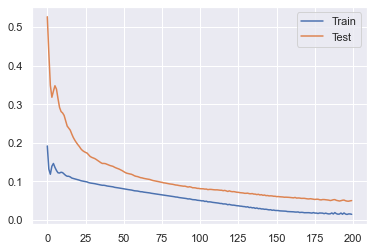

In [224]:
# design network
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2]), activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=80, validation_data=(test_X, test_y), verbose=0, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.show()

Tras 200 epoch de entrenamiento, se evalúa el modelo por medio de la evolución de la función de pérdida. Si bien se evidencia cierto overfitting (diferencia de MAE entre conjuntos de datos de entrenamiento y prueba), el rendimiento del modelo es aceptable. Considerando las simplificaciones realizadas, reducir la función de pérdida a valores cercanos a 0.5 parece suficiente para nuestros intereses. Otra manera estándar de evaluar el modelo corresponde al error medio cuadrático entre las predicciones y etiquetas:

In [225]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

yhat_train = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
test_y = test_y.reshape((len(test_y), 1))

In [227]:
rmse_train = sqrt(mean_squared_error(train_y, yhat_train))
print('Train RMSE: %.3f' % rmse_train)
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Train RMSE: 0.018
Test RMSE: 0.066


Tuve algunos problemas con revertir el escalamiento de la variable del precio de la leche, por lo que esta métrica se desvaloriza bastante. Sin embargo, aún nos permite mostrar la diferencia del error en cada conjunto de datos.

Luego, para mejorar el resultado del modelo debiesemos concentrar nuestros esfuerzos en la calidad de los atributos. Estudiar el efecto de considerar más lags, estadísticas acumladas adicionales, además de un análisis específico de la relevancia de cada variable sobre el precio de la leche. También es tremendamente relevante la completitud de las series de tiempo, o en su defecto, un criterio adecuado para su interpolación. 

Además se podrían incluir nuevas variables. Por ejemplo, podría ser interesante considerar el precio de la leche vegetal, estimado como un sustituto de la leche tradicional. O en el contexto de índices macroeconómicos, el IPC podría tener cierta relevancia. O incluso, un poco por diversión, me gustaría contar con algún factor emocional del gremio lechero.

Por otro lado, una afinación de los hiperparámetros del modelo y los criterios de entrenamiento debiesen tener un impacto considerable en el resultado del modelo.

Finalmente, para responder la pregunta ¿Cómo podría ayudar modelos de este tipo a combatir el cambio climático? (más allá de la utilidad directa del interés por predecir el precio de la leche por la industria lechera), conviene replantear el enfoque a: cuáles son los factores ambientales esperados para obtener determinado precio de leche. Por ejemplo hipotético, mayores precipitaciones (cuya variación podría identificarse como consecuencia del cambio climático) hacen crecer más pasto, más vacas y leche, mayor oferta y menor precio. A su vez, más vacas producen un incremento de gases invernadero (derivados tanto de la actividad humana y la industria lechera, como del metano producido por la vaca). Por lo tanto, es posible identificar relaciones no lineales entre la producción y precio de la leche con el cambio climático, que podrían ser adecuadas de estudiar con un enfoque de predicción similar al presentado en este desafío.